In [11]:
pip install imblearn

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 235.6/235.6 kB 4.7 MB/s eta 0:00:00:00:01
Note: you may need to restart the kernel to use updated packages.


In [1]:
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from tensorflow.python.keras  import utils
from keras.utils import to_categorical
from sklearn.utils import class_weight, resample
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn import preprocessing
from scipy import stats
import numpy as np
import statsmodels.api as sm
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix, accuracy_score
from sklearn import metrics
import sagemaker
from sagemaker import get_execution_role
import pandas as pd
from sklearn.preprocessing import LabelEncoder


sagemaker.config INFO - Not applying SDK defaults from location: /etc/xdg/sagemaker/config.yaml
sagemaker.config INFO - Not applying SDK defaults from location: /home/ec2-user/.config/sagemaker/config.yaml


Data Loading

In [4]:
ecg_df=pd.read_csv(r"C:\Users\USER\Desktop\mitbih\MIT-BIH Arrhythmia Database.csv")

AWS Data Loading

In [12]:
sagemaker_session = sagemaker.Session()
role = get_execution_role()

s3_uri = 's3://psutgrad/MIT-BIH Arrhythmia Database.csv'

# Download the data to SageMaker instance
sagemaker_session.download_data(path='local/path', bucket='psutgrad', key_prefix='MIT-BIH Arrhythmia Database.csv')

ecg_df= pd.read_csv('local/path/MIT-BIH Arrhythmia Database.csv')



In [5]:
ecg_df

,record,type,0_pre-RR,0_post-RR,0_pPeak,0_tPeak,0_rPeak,0_sPeak,0_qPeak,0_qrs_interval,...,1_qPeak,1_qrs_interval,1_pq_interval,1_qt_interval,1_st_interval,1_qrs_morph0,1_qrs_morph1,1_qrs_morph2,1_qrs_morph3,1_qrs_morph4
0,101,N,76,313.0,0.074347,-0.160548,1.036401,-0.285662,-0.026824,41,...,0.025930,2,18,22,2,0.025930,0.025930,0.025930,0.025436,0.025436
1,101,N,313,315.0,-0.052079,-0.264784,0.886597,-0.366298,-0.059710,21,...,-0.042009,26,27,62,9,-0.042009,-0.029498,0.005012,0.030892,0.002986
2,101,N,315,321.0,-0.062151,-0.296983,0.991859,-0.410306,-0.065686,22,...,0.009528,3,8,12,1,0.009528,0.009528,0.008786,0.008786,0.008368
3,101,N,321,336.0,-0.063322,-0.281386,1.034903,-0.403880,-0.071750,22,...,-0.020536,6,9,16,1,-0.020536,-0.020257,-0.018965,-0.016968,-0.014555
4,101,N,336,344.0,-0.062915,1.046914,1.046408,1.046408,-0.074639,11,...,0.016053,16,5,31,10,0.016053,0.006742,0.002782,-0.007798,-0.051155
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
100684,234,N,240,241.0,-0.110230,1.420339,1.403346,1.403346,-0.115682,14,...,-0.069234,5,6,20,9,-0.069234,-0.068378,-0.065373,-0.060779,-0.054383
100685,234,N,241,243.0,-0.119014,1.424782,1.420328,1.420328,-0.134406,13,...,-0.069530,7,5,20,8,-0.069530,-0.069290,-0.066317,-0.053437,-0.045120
100686,234,N,243,252.0,0.173524,-0.443214,1.436878,-0.714642,-0.136431,38,...,-0.089396,9,7,24,8,-0.089396,-0.088155,-0.078611,-0.066763,-0.058650
100687,234,N,252,244.0,-0.119820,-0.401522,1.337051,-0.688560,-0.125076,27,...,-0.065487,3,1,12,8,-0.065487,-0.065487,-0.064941,-0.064941,-0.061120


In [3]:
from scipy.stats import spearmanr


Checking for Correlation (Pearson vs kendall tau ( handles outliers better due to ranking ))

In [25]:
X = ecg_df.drop('type', axis=1)
lb = LabelEncoder()
y = lb.fit_transform(ecg_df['type'])
combined_df = pd.concat([X, pd.Series(y, name='Target')], axis=1)
correlation_with_target = combined_df.corr()['Target'] # Pearson correlation
print(correlation_with_target)

0_pre-RR          0.024558
0_post-RR        -0.026548
0_pPeak           0.008271
0_tPeak          -0.114181
0_rPeak          -0.136878
0_sPeak          -0.081515
0_qPeak          -0.050571
0_qrs_interval    0.018630
0_pq_interval     0.112585
0_qt_interval     0.147019
0_st_interval     0.163463
0_qrs_morph0     -0.050571
0_qrs_morph1     -0.012297
0_qrs_morph2      0.030095
0_qrs_morph3     -0.069901
0_qrs_morph4     -0.142652
1_pre-RR          0.024558
1_post-RR        -0.026548
1_pPeak          -0.081184
1_tPeak          -0.062652
1_rPeak          -0.037891
1_sPeak           0.192179
1_qPeak           0.096307
1_qrs_interval   -0.028683
1_pq_interval     0.046039
1_qt_interval     0.029965
1_st_interval     0.050799
1_qrs_morph0      0.096307
1_qrs_morph1      0.079644
1_qrs_morph2      0.041493
1_qrs_morph3      0.024639
1_qrs_morph4      0.076302
Target            1.000000
Name: Target, dtype: float64


In [27]:
from scipy.stats import kendalltau

X = ecg_df.drop('type', axis=1)

# Calculate Kendall Tau correlation for each feature
kendall_corr_results = {}

for column in X.columns:
    tau, _ = kendalltau(X[column], ecg_df['type'])
    kendall_corr_results[column] = tau

# Convert results to a DataFrame for better display
kendall_corr_df = pd.DataFrame(list(kendall_corr_results.items()), columns=['Feature', 'Kendall_Correlation'])

# Print the results
print(kendall_corr_df)

           Feature  Kendall_Correlation
0         0_pre-RR            -0.426706
1        0_post-RR             0.147061
2          0_pPeak             0.276409
3          0_tPeak             0.108775
4          0_rPeak            -0.257272
5          0_sPeak            -0.240446
6          0_qPeak            -0.038520
7   0_qrs_interval             0.008513
8    0_pq_interval             0.139918
9    0_qt_interval             0.173623
10   0_st_interval             0.202168
11    0_qrs_morph0            -0.038520
12    0_qrs_morph1            -0.093713
13    0_qrs_morph2            -0.156392
14    0_qrs_morph3            -0.176152
15    0_qrs_morph4            -0.183792
16        1_pre-RR            -0.426706
17       1_post-RR             0.147061
18         1_pPeak            -0.036160
19         1_tPeak             0.139426
20         1_rPeak             0.020766
21         1_sPeak             0.003461
22         1_qPeak            -0.048077
23  1_qrs_interval             0.086023


Checking For Outliers

              record       0_pre-RR      0_post-RR        0_pPeak  \
count  100689.000000  100689.000000  100689.000000  100689.000000   
mean      173.730984     279.400947     278.588207       0.049772   
std        51.673158      81.915453      81.124963       0.168789   
min       100.000000      11.000000       6.000000      -3.094391   
25%       115.000000     230.000000     230.000000      -0.054749   
50%       203.000000     267.000000     266.000000       0.015865   
75%       219.000000     324.000000     322.000000       0.125809   
max       234.000000    2114.000000    2114.000000       3.821118   

             0_tPeak        0_rPeak        0_sPeak        0_qPeak  \
count  100689.000000  100689.000000  100689.000000  100689.000000   
mean        0.372262       1.054485      -0.134376      -0.090466   
std         0.739879       0.617508       1.027590       0.189436   
min        -2.006422      -2.372835      -3.622550      -3.871359   
25%        -0.249060       0.7540

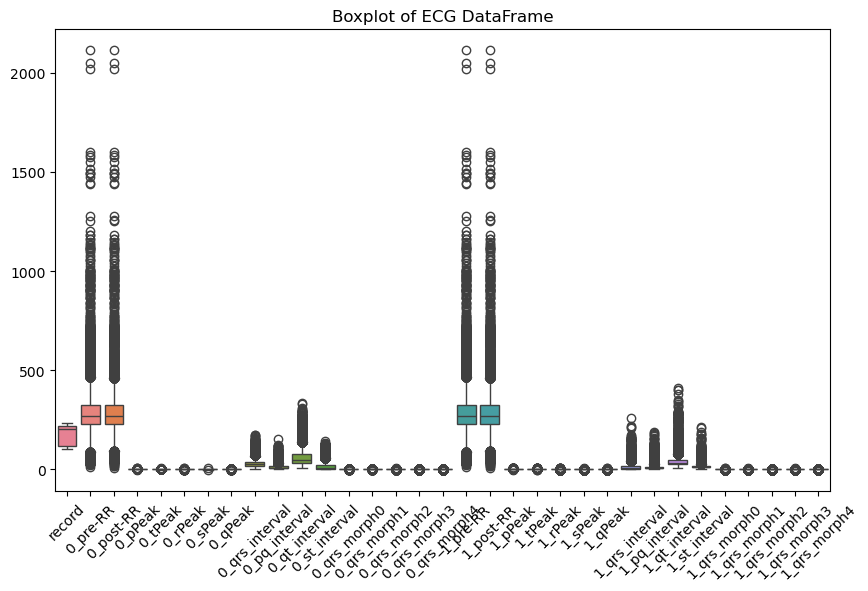

Number of  Rows with outliers:
record            46243
type              46243
0_pre-RR          46243
0_post-RR         46243
0_pPeak           46243
0_tPeak           46243
0_rPeak           46243
0_sPeak           46243
0_qPeak           46243
0_qrs_interval    46243
0_pq_interval     46243
0_qt_interval     46243
0_st_interval     46243
0_qrs_morph0      46243
0_qrs_morph1      46243
0_qrs_morph2      46243
0_qrs_morph3      46243
0_qrs_morph4      46243
1_pre-RR          46243
1_post-RR         46243
1_pPeak           46243
1_tPeak           46243
1_rPeak           46243
1_sPeak           46243
1_qPeak           46243
1_qrs_interval    46243
1_pq_interval     46243
1_qt_interval     46243
1_st_interval     46243
1_qrs_morph0      46243
1_qrs_morph1      46243
1_qrs_morph2      46243
1_qrs_morph3      46243
1_qrs_morph4      46243
dtype: int64


In [4]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

# Assuming 'ecg_df' is your DataFrame

# Select numerical columns for summary statistics
numerical_cols = ecg_df.select_dtypes(include=['number']).columns
summary_stats = ecg_df[numerical_cols].describe()
print(summary_stats)

# Box plot to visualize outliers
plt.figure(figsize=(10, 6))
sns.boxplot(data=ecg_df[numerical_cols])
plt.title("Boxplot of ECG DataFrame")
plt.xticks(rotation=45)  # Adjust the rotation angle as needed
plt.show()

# Identify and print rows with outliers using the IQR method
Q1 = ecg_df[numerical_cols].quantile(0.25)
Q3 = ecg_df[numerical_cols].quantile(0.75)
IQR = Q3 - Q1

outliers = ((ecg_df[numerical_cols] < (Q1 - 1.5 * IQR)) | (ecg_df[numerical_cols] > (Q3 + 1.5 * IQR))).any(axis=1)
outlier_rows = ecg_df[outliers]
print("Number of  Rows with outliers:")
print(outlier_rows.count())


Checking for Missing Values

In [5]:
counter=0
for index, row in ecg_df.iterrows():
    for col in ecg_df.columns:
        if pd.isnull(row[col]):
            counter=counter+1
            print(f"Missing value in row {index}, column {col}")
if(counter==0):
    print("No missing values found")

No missing values found


Checking Data Distribution

In [6]:
ecg_df['type'].value_counts()

type
N       90083
VEB      7009
SVEB     2779
F         803
Name: count, dtype: int64

Dropping the column 'Q' due to extremely low frequency

In [13]:
mask = ecg_df['type'] =='Q'
ecg_df=ecg_df[~mask]

Plotting the distribution of the classes

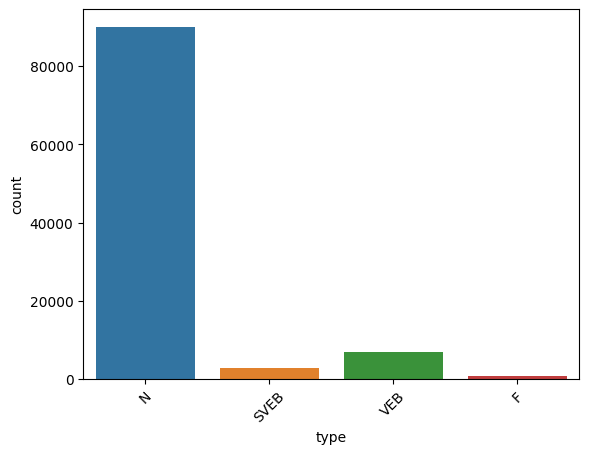

In [38]:
sns.countplot(x='type', data = ecg_df)
plt.xticks(rotation=45)
plt.show()

Removing the column 'Record' due to uselessness

In [14]:
ecg_df= ecg_df.drop(columns=['record'])

Downsampling the leading class

In [15]:
n_rows = ecg_df[ecg_df['type'] == 'N']
rows_to_keep = int(len(n_rows) * 0.20)
n_rows = n_rows.sample(n=rows_to_keep, random_state=42)
ecg_df = ecg_df[ecg_df['type'] != 'N']
ecg_df = pd.concat([ecg_df, n_rows])

Label Encoding

In [16]:
X = ecg_df.drop('type', axis=1)
y = ecg_df['type']
lb=LabelEncoder()
y=lb.fit_transform(y)

In [53]:
y

array([2, 2, 2, ..., 1, 1, 1])

Splitting the data before upsampling using SMOTE to avoid leakage

In [17]:
x_train, x_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

Splitting for validation

In [18]:
x_train, x_val, y_train, y_val = train_test_split(x_train, y_train, test_size=0.2, random_state=42)

SelectKBest (Feature Selection) (Skipped, please check report)

In [ ]:
#from sklearn.feature_selection import SelectKBest
#from sklearn.feature_selection import f_classif
#k = 10 #gradually increased
#selector = SelectKBest(score_func=f_classif, k=k)
#X_train_selected = selector.fit_transform(X_train, y_train)
#selected_feature_indices = selector.get_support(indices=True)
#print("Selected feature indices:", selected_feature_indices)

SMOTE

In [19]:
from imblearn.over_sampling import SMOTE
import numpy as np
import pandas as pd
smote = SMOTE()
x_train2, y_train2 = smote.fit_resample(x_train, y_train)
print("Before SMOTE:")
print(pd.Series(y_train).value_counts())
print("After SMOTE:")
print(pd.Series(y_train2).value_counts())

Before SMOTE:
1    11541
3     4492
2     1758
0      517
dtype: int64
After SMOTE:
0    11541
2    11541
1    11541
3    11541
dtype: int64


Splitting the data then robust scaling it to avoid data leakage

In [20]:
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import RobustScaler
robust_scaler = RobustScaler()

# Fit the scaler on the training data and transform the training data
X_train_scaled = robust_scaler.fit_transform(x_train2)

# Transform the validation and test data using the same scaler
X_val_scaled = robust_scaler.transform(x_val)
X_test_scaled = robust_scaler.transform(x_test)


In [21]:
len(X_train_scaled)

46164

In [22]:
len(y_train2)

46164

MinMax Scaling (Skipped due to lowering model's performance)

In [ ]:
#from sklearn.preprocessing import MinMaxScaler
#scalern = MinMaxScaler()
#X_train_scaledn = scalern.fit_transform(X_train_scaled)
#X_val_scaledn = scalern.transform(X_val_scaled)
#X_test_scaledn = scalern.transform(X_test_scaled)

In [23]:
from tensorflow.keras import Sequential,utils
from tensorflow.keras.layers import Flatten, Dense, Conv1D, MaxPool1D, Dropout
from keras.models import Sequential
from keras.layers import Conv1D, MaxPooling1D, Flatten, Dense, Dropout, GRU

In [18]:
os.environ['CUDA_VISIBLE_DEVICES'] = "0"

Model Architecture (CNN and GRU)

In [24]:
model = Sequential()

model.add(Conv1D(filters=32, kernel_size=3, padding='same', activation='relu', input_shape=(x_train.shape[1], 1)))
model.add(Conv1D(filters=64, kernel_size=3, padding='same', activation='relu'))
model.add(Conv1D(filters=128, kernel_size=5, padding='same', activation='relu'))

model.add(MaxPooling1D(pool_size=3, strides=2, padding='same'))
model.add(Dropout(0.2))

model.add(Conv1D(filters=256, kernel_size=3, padding='same', activation='relu'))
model.add(Conv1D(filters=512, kernel_size=3, padding='same', activation='relu'))
model.add(MaxPooling1D(pool_size=3, strides=2, padding='same'))
model.add(Dropout(0.2))

gru_units = 512 
model.add(GRU(gru_units))

model.add(Dense(units=512, activation='relu'))
model.add(Dropout(0.2))
model.add(Dense(units=1024, activation='relu'))
model.add(Dropout(0.2))

model.add(Flatten())

model.add(Dense(units=4, activation='softmax'))


2024-01-23 21:24:35.505475: E tensorflow/compiler/xla/stream_executor/cuda/cuda_driver.cc:268] failed call to cuInit: CUDA_ERROR_NO_DEVICE: no CUDA-capable device is detected


Compiling the model with Adam optimizer, which has the 0.001 Learning Rate

In [25]:
model.compile(optimizer='adam', loss = 'sparse_categorical_crossentropy', metrics=['accuracy'])

Custom adam's learning  rate

In [ ]:
#from tensorflow.keras.optimizers import Adam
#custom_learning_rate = 0.001
#custom_optimizer = Adam(learning_rate=custom_learning_rate)
#model.compile(optimizer=custom_optimizer, loss='sparse_categorical_crossentropy', metrics=['accuracy'])

SGD optimization Check

In [15]:
#from tensorflow.keras.optimizers import SGD
#custom_learning_rate_sgd = 0.001
#custom_optimizer_sgd = SGD(learning_rate=custom_learning_rate_sgd)
#model.compile(optimizer=custom_optimizer_sgd, loss='sparse_categorical_crossentropy', metrics=['accuracy'])

Training the model with Early Stopping to avoid overfitting, with an epoch of 40 that was increased linearly manually.

In [26]:
from tensorflow.keras.callbacks import EarlyStopping

# Define the EarlyStopping callback
early_stopping = EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)

# Use the EarlyStopping callback in the fit method
history = model.fit(X_train_scaled, y_train2, validation_data=(X_val_scaled, y_val), epochs=40, callbacks=[early_stopping])


Epoch 1/40
1443/1443 [==============================] - 95s 64ms/step - loss: 0.3579 - accuracy: 0.8694 - val_loss: 0.1963 - val_accuracy: 0.9382
Epoch 2/40
1443/1443 [==============================] - 91s 63ms/step - loss: 0.1469 - accuracy: 0.9543 - val_loss: 0.2041 - val_accuracy: 0.9401
Epoch 3/40
1443/1443 [==============================] - 92s 64ms/step - loss: 0.1110 - accuracy: 0.9660 - val_loss: 0.1596 - val_accuracy: 0.9471
Epoch 4/40
1443/1443 [==============================] - 91s 63ms/step - loss: 0.0891 - accuracy: 0.9725 - val_loss: 0.1307 - val_accuracy: 0.9626
Epoch 5/40
1443/1443 [==============================] - 92s 63ms/step - loss: 0.0775 - accuracy: 0.9769 - val_loss: 0.1126 - val_accuracy: 0.9677
Epoch 6/40
1443/1443 [==============================] - 93s 64ms/step - loss: 0.0709 - accuracy: 0.9773 - val_loss: 0.1338 - val_accuracy: 0.9607
Epoch 7/40
1443/1443 [==============================] - 92s 64ms/step - loss: 0.0620 - accuracy: 0.9804 - val_loss: 0.1255 -

Saving model as H5 format to be used later for prediciton by being triggered by the pipeline

In [53]:
model.save("ecggrad.h5")

/home/ec2-user/anaconda3/envs/tensorflow2_p310/lib/python3.10/site-packages/keras/src/engine/training.py:3000: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


In [28]:
import boto3
from botocore.exceptions import NoCredentialsError
from keras.models import load_model

# Replace 'your_model.h5' with the name of your model file
model_filename = 'ecggrad.h5'

# Replace 'psutgrad' with your S3 bucket name
bucket_name = 'psutgrad'

# Replace 'your_s3_folder' with the folder inside your S3 bucket where you want to save the model
def upload_to_s3(local_file, s3_bucket, s3_folder):
    s3 = boto3.client('s3')
    try:
        s3.upload_file(local_file, s3_bucket, s3_folder + local_file)
        print(f"Model uploaded to S3 bucket {s3_bucket} in folder {s3_folder}")
    except FileNotFoundError:
        print(f"The file {local_file} was not found.")
    except NoCredentialsError:
        print("Credentials not available.")

# Save your Keras model to a local file
# Replace 'your_model' with the actual Keras model variable
model.save(model_filename)

# Upload the local model file to S3
upload_to_s3(model_filename, bucket_name, s3_folder)


Model uploaded to S3 bucket psutgrad in folder arn:aws:s3:::psutgrad


Test accuracy

In [27]:
results = model.evaluate(X_test_scaled, y_test)
print("Test Loss:", results[0])
print("Test Metrics:", results[1:])

179/179 [==============================] - 2s 13ms/step - loss: 0.1247 - accuracy: 0.9645
Test Loss: 0.12467353045940399
Test Metrics: [0.9645228981971741]


PLOT OF Training and accuracy 

Text(0.5, 0, 'epoch')

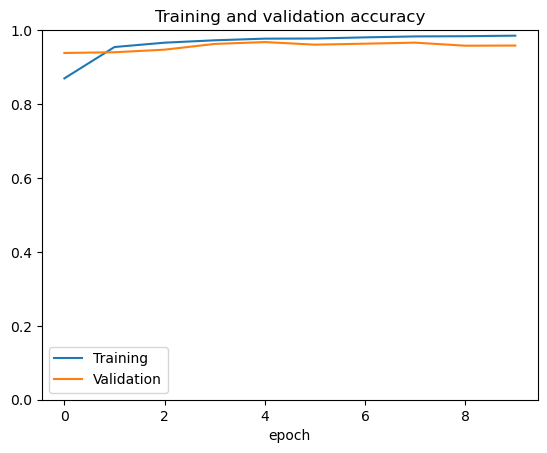

In [28]:
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.ylim(0,1)
plt.legend(['Training', 'Validation'])
plt.title("Training and validation accuracy")
plt.xlabel('epoch')

Training and validation plot

Text(0.5, 0, 'epoch')

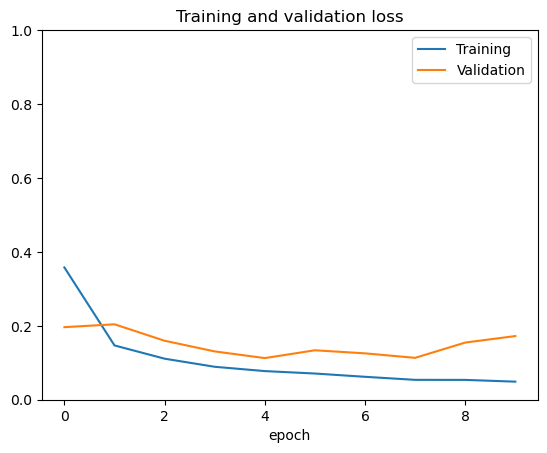

In [29]:
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.ylim(0,1)
plt.legend(['Training', 'Validation'])
plt.title("Training and validation loss")
plt.xlabel('epoch')

Other performance metrics

In [30]:
from sklearn.metrics import precision_recall_fscore_support

# Assuming y_val is your true labels and y_pred_classes is your predicted labels
y_pred = model.predict(X_val_scaled)

# Convert predictions to class labels
y_pred_classes = np.argmax(y_pred, axis=1)

# Calculate precision, recall, and f1 score
precision, recall, f1_score, _ = precision_recall_fscore_support(y_val, y_pred_classes, average='weighted')

# Print recall and f1 score
print(f'Recall: {recall:.4f}')
print(f'F1 Score: {f1_score:.4f}')
print(f'Precision: {precision:.4f}')


144/144 [==============================] - 2s 13ms/step
Recall: 0.9677
F1 Score: 0.9679
Precision: 0.9683


In [32]:
from sklearn.metrics import classification_report, confusion_matrix

# Assuming y_val is your true labels and y_pred_classes is your predicted labels
y_pred = model.predict(X_val_scaled)

# Convert predictions to class labels
y_pred_classes = np.argmax(y_pred, axis=1)

# Calculate confusion matrix
conf_matrix = confusion_matrix(y_val, y_pred_classes)

# Print confusion matrix
print("Confusion Matrix:")
print(conf_matrix)

# Generate and print a classification report
class_names = ["Normal", "SVEB", "VEB", "F"]  # Replace with your actual class names
classification_rep = classification_report(y_val, y_pred_classes, target_names=class_names)
print("Classification Report:")
print(classification_rep)


144/144 [==============================] - 2s 13ms/step
Confusion Matrix:
[[ 105    5    0    5]
 [   8 2791   27   37]
 [   2   19  421   11]
 [  13   13    8 1112]]
Classification Report:
              precision    recall  f1-score   support

      Normal       0.82      0.91      0.86       115
        SVEB       0.99      0.97      0.98      2863
         VEB       0.92      0.93      0.93       453
           F       0.95      0.97      0.96      1146

    accuracy                           0.97      4577
   macro avg       0.92      0.95      0.93      4577
weighted avg       0.97      0.97      0.97      4577

